In [1]:
import pathlib
import datetime
import re
import functools

In [2]:
import pandas

In [17]:
import iris
import iris.quickplot
import cartopy.crs

In [4]:
import matplotlib

In [5]:
%matplotlib inline

In [6]:
root_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/'

## Exploring traffic data

In [7]:
traffic_dir = 'Traffic'
traffic_root_path = pathlib.Path(root_data_dir, traffic_dir)

In [8]:
traffic_obs_dir = 'Traffic_flow'
traffic_obs_path = pathlib.Path(traffic_root_path, traffic_obs_dir)
nowcast_dir = 'Model'
nowcast_path = pathlib.Path(traffic_root_path, nowcast_dir)

## Exploring Nowcast data

In [9]:
sample_path = pathlib.Path(nowcast_path, '201804051100.nc')
sample_nowcast_cube = iris.load(str(sample_path))
sample_nowcast_cube

[<iris 'Cube' of temperature / (degC) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of wind_speed_of_gust / (knots) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of precipitation rate / (mm/hr) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of precip accum 60-min / (mm) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of precipitation type / (1) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of Visibility / (1) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of wind speed / (knots) (projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of wind direction / (degrees) (projection_y_coordinate: 704; projection_x_coordinate: 548)>]

In [10]:
nowcast_cube_list = iris.load([p1.as_posix() for p1 in pathlib.Path(nowcast_path).glob('20180401*')])


In [13]:
[c1.name() for c1 in nowcast_cube_list]

['temperature',
 'wind_speed_of_gust',
 'precipitation rate',
 'precip accum 60-min',
 'precipitation type',
 'Visibility',
 'wind speed',
 'wind direction']

In [15]:
nowcast_cube_list[0]

<iris 'Cube' of temperature / (degC) (time: 23; projection_y_coordinate: 704; projection_x_coordinate: 548)>

/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,
/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'axis'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


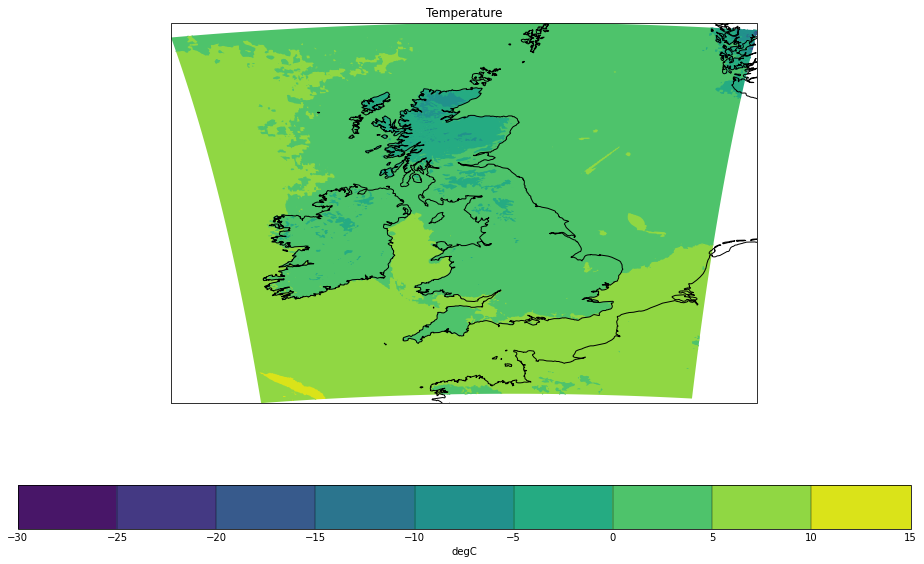

In [19]:
fig_nowcast_temp = matplotlib.pyplot.figure('nowcast_temp', figsize=(16,10))
ax_nowcast_temp = fig_nowcast_temp.add_subplot(1,1,1,title='2m temperature', projection=cartopy.crs.PlateCarree())
iris.quickplot.contourf(nowcast_cube_list[0][0,:,:], axis=ax_nowcast_temp)
ax_nowcast_temp.coastlines()

In [162]:
temp_cube_day = nowcast_cube_list[0]

Cube coordinates are in transverse mercator, so we will need to translate the latitude/longitude that the site location is specified in into transevrse mercator to be able to extract a time series for a site.

This is what the existing coordinates look like:

In [65]:
nowcast_cube_list[0].coord('projection_x_coordinate').points[280], nowcast_cube_list[0].coord('projection_y_coordinate').points[500],

(322000.0, 222000.0)

here we get the projection of roughly the latitude/longitude for exeter

In [70]:
site_projected = nowcast_cube_list[0].coord_system().as_cartopy_crs().transform_point(-3.13, 51.89, cartopy.crs.PlateCarree())
site_projected

/opt/scitools/environments/experimental/current/lib/python3.6/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


(322243.5553190777, 221923.74279872957)

In [73]:
time_series_temperature_exeter_cube = nowcast_cube_list[0].interpolate([
    ('projection_x_coordinate', site_projected[0]),
    ('projection_y_coordinate',  site_projected[1])],iris.analysis.Linear()) # get time series at Exeter
time_series_temperature_exeter_cube

Temperature (degC),time
Shape,23
Dimension coordinates,
time,x
Auxiliary coordinates,
forecast_reference_time,x
Scalar coordinates,
forecast_period,0 second
height,1.65 m
projection_x_coordinate,322243.5553190777 m
projection_y_coordinate,221923.74279872957 m


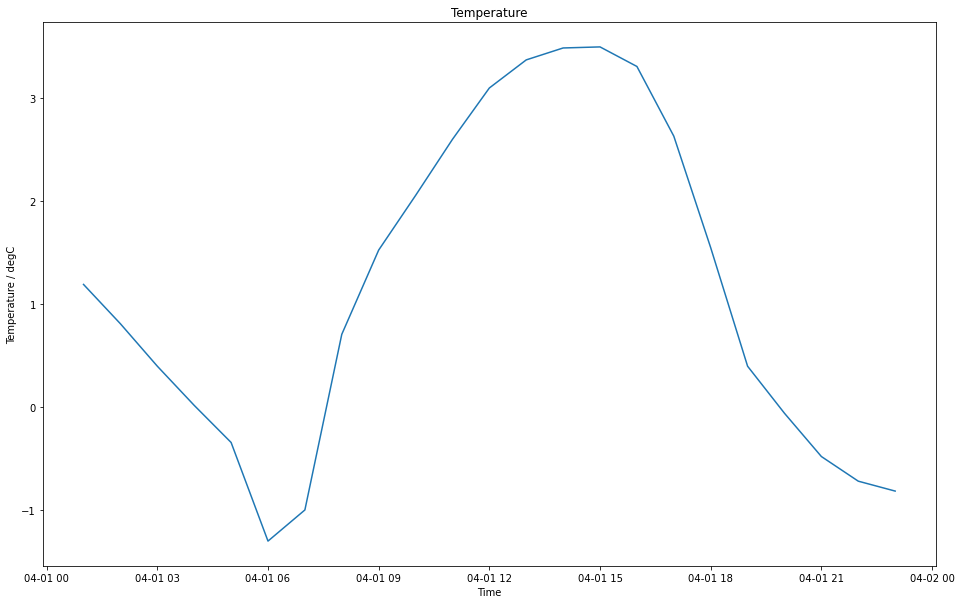

In [79]:
fig_ts = matplotlib.pyplot.figure('exeter_temp_ts', figsize=(16,10))
ax_ts = fig_ts.add_subplot(1,1,1,title='Exeter Temperature Time Series')
iris.quickplot.plot(time_series_temperature_exeter_cube)

## Exploring traffic data

In [86]:
site_traffic_path_list = list(traffic_obs_path.glob('*.txt'))
site_traffic_path_list[:10]

[PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/4447.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/4153.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/8787.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/8493.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/1900.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/10189.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/762.txt'),
 PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Traffic/Traffic_flow/9611.txt'),
 PosixPath('/project/inf

In [87]:
sample_traffic_path = list(traffic_obs_path.glob('*.txt'))[1]

In [88]:
with open(sample_traffic_path) as sample_traffic_file:
    t1 = sample_traffic_file.readlines()
print(''.join(t1[:10]))

Site Id: 4153
Site Lat/Long: 52.3480870814361 -1.80593323261389
Site description/location: MIDAS site at M40/9701M priority 1 on link 111002101; GPS Ref: 413316;272240; Southbound
2016-03-31T00:14:00 Total Volume: 79
2016-03-31T00:29:00 Total Volume: 91
2016-03-31T00:44:00 Total Volume: 75
2016-03-31T00:59:00 Total Volume: 129
2016-03-31T01:14:00 Total Volume: 100
2016-03-31T01:29:00 Total Volume: 115
2016-03-31T01:44:00 Total Volume: 142



In [89]:
t1[1]

'Site Lat/Long: 52.3480870814361 -1.80593323261389\n'

In [90]:
pattern_lat_lon = 'Site Lat/Long: (?P<latitude>[-\d\.]+)(\s*)(?P<longitude>[-\d\.]+)'

In [91]:
def get_lat_lon(location_info_str, re_pattern):
    match1 = re.search(re_pattern, location_info_str)
    return (float(match1.group('latitude')), float(match1.group('longitude')))

In [92]:
get_lat_lon(t1[1], pattern_lat_lon)

(52.3480870814361, -1.80593323261389)

In [93]:
pattern_site_id = 'Site Id: (?P<siteid>[\d]+)'

In [94]:
def get_site_id(site_info_str, re_pattern):
    match1 = re.search(re_pattern, site_info_str)
    return int(match1.group('siteid'))

In [95]:
get_site_id(t1[0], pattern_site_id)

4153

We will process the text file into a dataframe with columns for date & time and traffic flow.

In [96]:
sitefile_chunksize = 20000

In [97]:
def extract_values(input_str, pattern1, site_id):
    match1 = re.search(pattern1, input_str)
    if match1 is not None:
        dt1 = datetime.datetime(
            year=int(match1.group('year')),
            month=int(match1.group('month')),
            day=int(match1.group('day')),
            hour=int(match1.group('hour')),
            minute=int(match1.group('minute')),
        )
        traffic_volume = int(match1.group('volume'))
    else:
        dt1 = None
        traffic_volume = 0
    return {'timestamp': dt1, f'volume_{site_id}': traffic_volume}

In [98]:
pattern1 = r'(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T(?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2}) Total Volume: (?P<volume>\d+)'

In [99]:
sample_site_df = pandas.DataFrame.from_records([extract_values(r1, pattern1, int(sample_traffic_path.stem)) for r1 in t1[3:]])
sample_site_df

,timestamp,volume_4153
0,2016-03-31 00:14:00,79
1,2016-03-31 00:29:00,91
2,2016-03-31 00:44:00,75
3,2016-03-31 00:59:00,129
4,2016-03-31 01:14:00,100
...,...,...
132846,2020-03-30 22:59:00,32
132847,2020-03-30 23:14:00,67
132848,2020-03-30 23:29:00,80
132849,2020-03-30 23:44:00,71


In [100]:
import dask.dataframe

In [101]:
def create_data_frame(path1):
    Site_metadata = {}
    with open(path1) as site_file:
        site_traffic_raw = site_file.readlines()
    site_id = get_site_id(site_traffic_raw[0], pattern_site_id)     
    site_lat_lon = get_lat_lon(site_traffic_raw[1], pattern_lat_lon)     
    site_df1 = pandas.DataFrame.from_records([extract_values(r1, pattern1, site_id) for r1 in site_traffic_raw[3:]])
    site_df1['timestamp'] = pandas.to_datetime(site_df1['timestamp'])
    site_df1 = site_df1[~site_df1['timestamp'].isna()]
    site_metadata = {site_id: site_lat_lon}
    return site_df1, site_metadata


In [102]:
site_traffic_list = []
metadata_dict = {}
for path1 in list(site_traffic_path_list)[0:10]:
    site_traffic_data, site_metadata = create_data_frame(path1)
    metadata_dict.update(site_metadata)
    site_traffic_list += [site_traffic_data]
merge_df1 = functools.reduce(lambda x,y: pandas.merge(x,y,on='timestamp',how='outer'), site_traffic_list)
merge_df1

,timestamp,volume_4447,volume_4153,volume_8787,volume_8493,volume_1900,volume_10189,volume_762,volume_9611,volume_5467,volume_5173
0,2016-03-31 00:14:00,101.0,79.0,NaN,54.0,35.0,121.0,98.0,91.0,155.0,56.0
1,2016-03-31 00:29:00,99.0,91.0,NaN,44.0,47.0,89.0,81.0,66.0,98.0,197.0
2,2016-03-31 00:44:00,93.0,75.0,NaN,55.0,33.0,93.0,46.0,80.0,111.0,108.0
3,2016-03-31 00:59:00,82.0,129.0,NaN,61.0,38.0,84.0,58.0,50.0,67.0,128.0
4,2016-03-31 01:14:00,107.0,100.0,NaN,51.0,38.0,91.0,65.0,70.0,83.0,144.0
...,...,...,...,...,...,...,...,...,...,...,...
139938,2020-02-10 15:47:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,920.0
139939,2020-03-02 01:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0
139940,2020-03-04 01:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0
139941,2020-03-20 10:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,940.0


In [103]:
print(metadata_dict)

{4447: (51.257305514824, -0.089649577003965), 4153: (52.3480870814361, -1.80593323261389), 8787: (54.9392249135127, -1.63046132812333), 8493: (52.8769366295765, -1.621575392169), 1900: (52.0580075097866, 1.10444377223221), 10189: (53.7095624494508, -1.4056460981257), 762: (51.7676665177455, -0.234429547059426), 9611: (53.4363525802161, -1.24216329880321), 5467: (51.4177338627167, 0.35262319741963), 5173: (51.8609702952411, -0.431176477061259)}


Lets find traffic observations that match the 1 day of weather data that we loaded earlier.

In [114]:
traffic_day = merge_df1[(merge_df1.timestamp> datetime.datetime(2018,4,1,0,0,0)) & (merge_df1.timestamp< datetime.datetime(2018,4,2,0,0,0)) ]

In [125]:
site_dict_projected = {
    site_id: nowcast_cube_list[0].coord_system().as_cartopy_crs().transform_point(site_loc[1], site_loc[0], cartopy.crs.PlateCarree())
    for site_id, site_loc in metadata_dict.items()}
site_dict_projected

{4447: (533287.6249280431, 152694.9422921989),
 4153: (413217.9302029508, 272284.4692191847),
 8787: (423672.218789998, 560577.744592722),
 8493: (425465.86564025574, 331154.95057889365),
 1900: (612800.3771161309, 244553.44160362502),
 10189: (439226.316551849, 423871.10331819695),
 762: (521817.6483789735, 209190.2297887755),
 9611: (450339.1885868487, 393581.8990164891),
 5467: (563569.9784040854, 171427.06815896853),
 5173: (508020.34605242294, 219255.25285344076)}

In [128]:
[c1.name() for c1 in nowcast_cube_list[0].coords()]

['time',
 'projection_y_coordinate',
 'projection_x_coordinate',
 'forecast_period',
 'height',
 'forecast_reference_time']

Now we will create a dataframe of temperature observations to match the traffic observations

In [169]:
temp_traffic_dict = {'timestamp' : list(traffic_day['timestamp'])}
for site_id, site_projected in site_dict_projected.items():
    temp_traffic_dict.update( {f'{temp_cube_day.name()}_{site_id}':    
    temp_cube_day.interpolate([
    ('projection_x_coordinate', site_projected[0]),
    ('projection_y_coordinate',  site_projected[1]),
    ('time', [dt1.to_pydatetime() for dt1 in traffic_day.loc[:,'timestamp']]),],
    iris.analysis.Linear(),).data})

temp_traffic_df = pandas.DataFrame(temp_traffic_dict)

,timestamp,temperature_4447,temperature_4153,temperature_8787,temperature_8493,temperature_1900,temperature_10189,temperature_762,temperature_9611,temperature_5467,temperature_5173
0,2018-04-01 00:14:00,4.193160,3.354173,2.833369,3.535084,4.980598,2.860936,3.750330,2.737547,4.461065,3.033763
1,2018-04-01 00:29:00,4.094427,3.324351,2.794393,3.403977,4.946767,2.827147,3.734917,2.686465,4.438603,3.009289
2,2018-04-01 00:44:00,3.995694,3.294528,2.755417,3.272869,4.912937,2.793357,3.719503,2.635383,4.416142,2.984815
3,2018-04-01 00:59:00,3.896960,3.264706,2.716441,3.141761,4.879107,2.759568,3.704089,2.584300,4.393681,2.960341
4,2018-04-01 01:14:00,3.798227,3.234884,2.677465,3.010653,4.845276,2.725779,3.688675,2.533218,4.371219,2.935867
...,...,...,...,...,...,...,...,...,...,...,...
91,2018-04-01 22:59:00,3.406089,2.960529,2.331193,3.748783,4.696455,2.978210,3.595261,2.875538,4.207013,3.107299
92,2018-04-01 23:14:00,3.457052,2.847896,2.311657,3.737391,4.678108,2.990822,3.363564,2.855153,4.086393,2.931705
93,2018-04-01 23:29:00,3.508015,2.735263,2.292122,3.725999,4.659761,3.003434,3.131866,2.834769,3.965772,2.756110
94,2018-04-01 23:44:00,3.558978,2.622629,2.272587,3.714607,4.641414,3.016046,2.900169,2.814384,3.845152,2.580516
